# Estimating probability density functions using MLMC and MC

This exercise will explore a naive approach to the Kernel Density Estimation (KDE) problem using both Multilevel Monte Carlo (MLMC) and standard Monte Carlo (MC) methods. The goal is to estimate the probability density function (PDF) of the distance traveled by a projectile launched with uncertain initial conditions.

The purpose of this exercise is **not** to develop a state-of-the-art KDE method, but rather help you understand how to implement MLMC and compare it to MC in a simple setting. 

## Short description of the Kernel Density Estimation (KDE) method
Let $K_h$ be a kernel function with bandwidth $h$. Typically $K_h(x) = \frac{1}{h} K\left(\frac{x}{h}\right)$ where $K$ is a kernel function such as the Gaussian kernel ($K(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$). Let $U$ be a random variable with probability density function $f_U$. If $f_U$ is nicely behaved, we can approximate 
$$f_U(u) \approx \int K_h(u - v) f_U(v) dv = \mathbb{E}[K_h(u - U)].$$

The classical kernel density estimator is then given by the MC estimator
$$\hat{f}_U(u) = \frac{1}{M} \sum_{m=1}^M K_h(u - U^{(m)}),$$
where $U^{(m)}$ are independent samples of $U$.

We can also use MLMC to estimate $\mathbb{E}[K_h(u - U)]$ if we have a hierarchy of approximations $U_\ell$ of $U$ with increasing accuracy (and cost). The MLMC estimator is then given by
$$\tilde{f}_U(u) = \sum_{\ell=0}^L \frac{1}{M_\ell} \sum_{m=1}^{M_\ell} \left( K_h(u - U_\ell^{(m)}) - K_h(u - U_{\ell-1}^{(m)}) \right) + \frac{1}{M_0} \sum_{m=1}^{M_0} K_h(u - U_0^{(m)}),$$

(The lecturer suggests this method should be called GNOME: "Gaussian Noisy Monte Carlo Estimation", though it has seen little adoption in the literature.)

We have provided code to run MLMC and MC estimators for the projectile distance problem. You may choose to use said code as is, or modify it to suit your needs. We also provide some example code showing its usage.

## Too easy?
If you want a harder challenge, try to implmenet the MLMC variant of the Maximal Entropy method (Bierig and Chernov, 2016, https://www.sciencedirect.com/science/article/abs/pii/S0021999116001790) for approximating the PDF. Do note that this is significantly more challenging, and needs some normalization of the samples to match the basis functions chosen, and a Newton solver to find the coefficients of the basis functions (use ForwardDiff.jl for automatic differentiation to find the Jacobian).

In brief, the Maximal Entropy method approximates the PDF $f_U$ as
$$\tilde{f}_U(u) \approx \exp\left( \sum_{k=0}^P \lambda_k \phi_k(u) \right),$$
where $\phi_k$ are basis functions (e.g., Legendre polynomials) and $\lambda_k$ solves the nonlinear system
$$
\begin{cases}
\tilde{f}_U(u) := \exp\!\left( \displaystyle\sum_{k=0}^{N} \tilde{\lambda}_k \phi_k(u) \right),
& \tilde{\lambda}_k \in \mathbb{R}, \\[1em]
\tilde{\alpha}_k = \displaystyle\int_I \phi_k(u)\,\tilde{f}_U(u)\,du,
& 0 \le k \le N.
\end{cases}.
$$
where
$$\tilde{\alpha}_k = E_L(\phi_k(U)) \approx \mathbb{E}[\phi_k(U)]$$
are the MLMC estimates of the generalized moments of $U$.

In [36]:
# DON'T DO THIS IN PRODUCTION CODE
# This is just to ensure that the required packages are installed (for the notebook to run)
# We had some issues on JupyterLab where the environment was not properly activated

# These are packages we think you will need
using Pkg
Pkg.activate(joinpath(@__DIR__, "."))
Pkg.instantiate()
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("Parameters")
Pkg.add("Statistics")
Pkg.add("Random")
Pkg.add("LinearAlgebra")
Pkg.add("LaTeXStrings")

  Activating project at `~/projects/GeiloWinterSchoolUQ/notebooks`
   Resolving package versions...
     Project No packages added to or removed from `~/projects/GeiloWinterSchoolUQ/notebooks/Project.toml`
    Manifest No packages added to or removed from `~/projects/GeiloWinterSchoolUQ/notebooks/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/projects/GeiloWinterSchoolUQ/notebooks/Project.toml`
    Manifest No packages added to or removed from `~/projects/GeiloWinterSchoolUQ/notebooks/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/projects/GeiloWinterSchoolUQ/notebooks/Project.toml`
    Manifest No packages added to or removed from `~/projects/GeiloWinterSchoolUQ/notebooks/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/projects/GeiloWinterSchoolUQ/notebooks/Project.toml`
    Manifest No packages added to or removed from `~/pro

## Projectile distance model
Here we provicde some code to run the projectile model. To run the model, you should first define a parameter object, and call the function `projectile_distance`.

```julia
parameters = ProjectileParameters(
    initial_height = Uniform(8.0, 20.0),  # Initial height in meters
    initial_speed = Uniform(15.0, 25.0),   # Initial speed in m/s
    angle_in_degrees = Uniform(30.0, 60.0), # Launch angle in degrees
    mass = Uniform(0.5, 2.0),             # Mass in kg
    drag = Drag(
        ρ = Uniform(1.0, 1.3),            # Air density
        C_d = Uniform(0.4, 0.6),          # Drag coefficient
        A = Uniform(0.005, 0.02)          # Cross-sectional area
    )
)
distance = projectile_distance(rand(parameters); resolution=0.01)
```


In [25]:
using Parameters
using Distributions
using Statistics

import Random: rand, Dims, AbstractRNG
using Plots

@with_kw struct ProjectileParameters{HeightType, SpeedType, AngleType, MassType, DragType}
    initial_height::HeightType
    initial_speed::SpeedType
    angle_in_degrees::AngleType
    mass::MassType
    drag::DragType
end

function rand(uqParam::ProjectileParameters)
    h0 = uqParam.initial_height isa Real ? uqParam.initial_height : rand(uqParam.initial_height)
    v0 = uqParam.initial_speed isa Real ? uqParam.initial_speed : rand(uqParam.initial_speed)
    angle = uqParam.angle_in_degrees isa Real ? uqParam.angle_in_degrees : rand(uqParam.angle_in_degrees)
    m = uqParam.mass isa Real ? uqParam.mass : rand(uqParam.mass)
    ρ = uqParam.drag.ρ isa Real ? uqParam.drag.ρ : rand(uqParam.drag.ρ)
    C_d = uqParam.drag.C_d isa Real ? uqParam.drag.C_d : rand(uqParam.drag.C_d)
    A = uqParam.drag.A isa Real ? uqParam.drag.A : rand(uqParam.drag.A)
    return ProjectileParameters(
        initial_height = h0,
        initial_speed = v0,
        mass = m,
        angle_in_degrees = angle,
        drag = Drag(ρ=ρ, C_d=C_d, A=A)
    )
end

function rand(rng::AbstractRNG, uqParam::ProjectileParameters)
    h0 = uqParam.initial_height isa Real ? uqParam.initial_height : rand(rng, uqParam.initial_height)
    v0 = uqParam.initial_speed isa Real ? uqParam.initial_speed : rand(rng, uqParam.initial_speed)
    angle = uqParam.angle_in_degrees isa Real ? uqParam.angle_in_degrees : rand(rng, uqParam.angle_in_degrees)
    m = uqParam.mass isa Real ? uqParam.mass : rand(rng, uqParam.mass)
    ρ = uqParam.drag.ρ isa Real ? uqParam.drag.ρ : rand(rng, uqParam.drag.ρ)
    C_d = uqParam.drag.C_d isa Real ? uqParam.drag.C_d : rand(rng, uqParam.drag.C_d)
    A = uqParam.drag.A isa Real ? uqParam.drag.A : rand(rng, uqParam.drag.A)
    return ProjectileParameters(
        initial_height = h0,
        initial_speed = v0,
        mass = m,
        angle_in_degrees = angle,
        drag = Drag(ρ=ρ, C_d=C_d, A=A)
    )
end

function rand(rng::AbstractRNG, uqParam::ProjectileParameters, dims::Dims)
    ElementType = typeof(rand(rng, uqParam.initial_height))
    ParameterType = ProjectileParameters{ElementType, ElementType, ElementType, Drag{ElementType, ElementType, ElementType}}
    results = Array{ParameterType}(undef, dims)
    for idx in CartesianIndices(results)
        results[idx] = rand(rng, uqParam)
    end
    return results
end

function rand(uqParam::ProjectileParameters, dims::Dims)
    ElementType = typeof(rand(uqParam.initial_height))
    ParameterType = ProjectileParameters{ElementType, ElementType, ElementType, ElementType, Drag{ElementType, ElementType, ElementType}}
    results = Array{ParameterType}(undef, dims)
    for idx in CartesianIndices(results)
        results[idx] = rand(uqParam)
    end
    return results
end

"""
    projectile_motion(parameters::ProjectileParameters; endtime=50.0, resolution=0.01)
Simulate projectile motion given a `ProjectileParameters` instance.
# Arguments
- `parameters`: Instance of `ProjectileParameters` containing simulation parameters.
# Keyword Arguments
- `endtime`: Maximum simulation time (s)
- `resolution`: Time step for numerical integration (s)
# Returns
- `t`: Time vector
- `x`: Horizontal position vector (m)
- `y`: Vertical position vector (m)
# Description
This function extracts parameters from the `ProjectileParameters` instance
and calls the more general `projectile_motion` function to perform the simulation.
"""
function projectile_motion(parameters::ProjectileParameters; endtime=50.0, resolution=0.01)
    return projectile_motion(
        parameters.initial_height,
        endtime,
        parameters.initial_speed,
        parameters.angle_in_degrees,
        parameters.mass;
        drag = parameters.drag, dt = resolution
    )
end

"""
    projectile_motion(initial_height, endtime, initial_speed, launch_angle, mass; drag = v -> 0.0, dt = 0.01)

Simulate projectile motion with optional drag force.

# Arguments
- `initial_height`: Initial height of the projectile (m)
- `endtime`: Maximum simulation time (s)
- `initial_speed`: Initial speed of the projectile (m/s)
- `launch_angle`: Launch angle in degrees
- `mass`: Mass of the projectile (kg)

# Keyword Arguments
- `drag`: Drag force function that takes velocity as input (default: no drag)
- `dt`: Time step for numerical integration (default: 0.01 s)

# Returns
- `t`: Time vector
- `x`: Horizontal position vector (m)
- `y`: Vertical position vector (m)

# Description
Numerically integrates the equations of motion for a projectile under gravity
and optional drag force using Euler's method. The simulation stops when the
projectile hits the ground (y < 0) or when `endtime` is reached.
"""
function projectile_motion(initial_height, endtime, initial_speed, launch_angle, mass; drag = v -> 0.0, dt = 0.01)
    g = 9.81  # Acceleration due to gravity (m/s^2)
    θ = deg2rad(launch_angle)  # Convert angle to radians

    vx0 = initial_speed * cos(θ)
    vy0 = initial_speed * sin(θ)
    
    # Time vector
    t = 0:dt:endtime
    position = zeros(length(t), 2)
    velocity = zeros(length(t), 2)
    position[1, 1] = 0.0  # Initial x position
    position[1, 2] = initial_height  # Initial y position
    velocity[1, 1] = vx0  # Initial x velocity
    velocity[1, 2] = vy0  # Initial y velocity
    for i in 1:length(t)-1
        v = sqrt(velocity[i, 1]^2 + velocity[i, 2]^2)
        drag_force = drag(v)
        ax = -drag_force * (velocity[i, 1] / v) / mass
        ay = -g - drag_force * (velocity[i, 2] / v) / mass

        velocity[i+1, 1] = velocity[i, 1] + ax * dt
        velocity[i+1, 2] = velocity[i, 2] + ay * dt

        position[i+1, 1] = position[i, 1] + velocity[i, 1] * dt
        position[i+1, 2] = position[i, 2] + velocity[i, 2] * dt

        if position[i+1, 2] < 0
            position = position[1:i+1, :]
            t = t[1:i+1]
            break
        end
    end
    x = position[:, 1]
    y = position[:, 2]

    return t, x, y
end

function projectile_distance(parameters::ProjectileParameters; kwargs...)
    t, x, y = projectile_motion(parameters; kwargs...)
    return maximum(x)
end

function projectile_distance(args; kwargs...)
    t, x, y = projectile_motion(args...; kwargs...)
    return maximum(x)
end


@with_kw struct Drag{RhoType, CdType, AreaType}
    ρ::RhoType = 1.225  # Air density (kg/m^3)
    C_d::CdType = 0.47  # Drag coefficient
    A::AreaType  = 0.01  # Cross-sectional area (m^2)
end

function (d::Drag)(v)
    return 0.5 * d.ρ * d.C_d * d.A * v^2
end

In [27]:
using LinearAlgebra: norm
function optimal_mlmc_levels(tolerance, costs, variances)
    total_cost = sum(sqrt.(variances .* costs))
    required_samples = ceil.( (2 / tolerance^2) * total_cost * sqrt.(variances ./ costs) )
    return required_samples
end

function estimate_mlmc_variances(model, base_parameters, timestepsizes = [2^(-i) for i in 1:6], M = 1000)
    variances = []
    for (level, dt) in enumerate(timestepsizes)
        samples = []
        for sample in 1:M
            parameters = rand(base_parameters)
            fine_solution = model(parameters; resolution = dt)
            if level == 1
                push!(samples, fine_solution)
            else
                coarse_solution = model(parameters; resolution = timestepsizes[level-1])
                push!(samples, fine_solution - coarse_solution)
            end
        end
        
        push!(variances, norm(var(samples)))
    end
    return variances
end

function simulate_mlmc_samples(model, base_parameters, tolerance, variances, timestepsizes = [2^(-i) for i in 1:6])
    required_samples = optimal_mlmc_levels(tolerance, timestepsizes .^ (-1), variances)
    samples = []
    for (level, M) in enumerate(required_samples)
        push!(samples, [])
        for sample in 1:M
            parameters = rand(base_parameters)
            fine_solution = model(parameters; resolution = timestepsizes[level])
            if level == 1
                push!(samples[level], fine_solution)
            else
                coarse_solution = model(parameters; resolution = timestepsizes[level-1])
                push!(samples[level], (fine_solution, coarse_solution))
            end
        end
    end
    return samples
end

function mc_samples(model, base_parameters, M, timestepsize)
    samples = []
    for sample in 1:M
        parameters = rand(base_parameters)
        solution = model(parameters; resolution = timestepsize)
        push!(samples, solution)
    end
    return samples
end

function mc_estimate(mc_samples, g = x -> x)
    return mean(g.(mc_samples))
end

function mlmc_estimate(mlmc_samples, g = x -> x)
    mean_estimate = zero(typeof(g(mlmc_samples[1][1])))

    for level in 1:length(mlmc_samples)
        if level == 1
            mean_estimate += mean(g.(mlmc_samples[level]))
        else
            # last element is coarse, first is fine (only two elements per sample)
            mean_estimate += mean(g.(first.(mlmc_samples[level])) .- g.(last.(mlmc_samples[level])))
        end
    end
    return mean_estimate
end


mlmc_estimate (generic function with 2 methods)

## Interlude: Measuring convergence
This was not part of the exercise, but it may be useful to measure the convergence of the MLMC and MC estimators. 


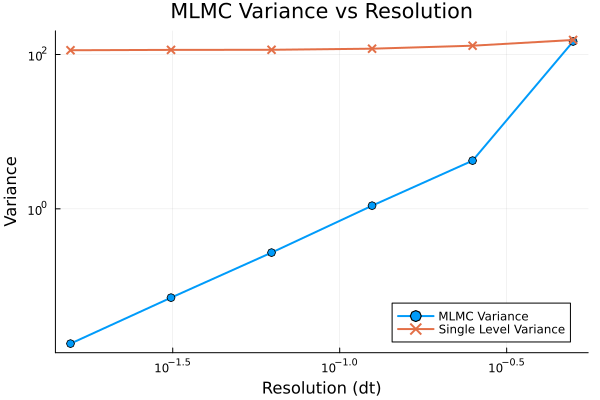

Tolerance: 0.5, MLMC Estimate: 53.450006096999786, Error: 7.484158107032172
Tolerance: 0.5, MC Estimate: 53.40909478589566, Error: 7.443246795928047
Tolerance: 0.25, MLMC Estimate: 49.53938515259912, Error: 3.573537162631503
Tolerance: 0.25, MC Estimate: 49.68970829178844, Error: 3.723860301820828
Tolerance: 0.125, MLMC Estimate: 47.92005573203917, Error: 1.954207742071553
Tolerance: 0.125, MC Estimate: 47.77834133442898, Error: 1.812493344461366
Tolerance: 0.0625, MLMC Estimate: 46.69399432570319, Error: 0.7281463357355733
Tolerance: 0.0625, MC Estimate: 46.76407612149299, Error: 0.7982281315253772
Tolerance: 0.03125, MLMC Estimate: 46.29084038521688, Error: 0.32499239524926793
Tolerance: 0.03125, MC Estimate: 46.304433767770746, Error: 0.33858577780313226
Tolerance: 0.015625, MLMC Estimate: 46.06773277476548, Error: 0.10188478479786767
Tolerance: 0.015625, MC Estimate: 46.077447627027986, Error: 0.11159963706037246


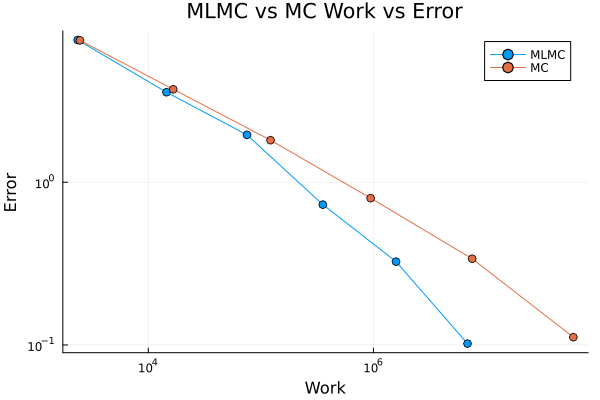

In [31]:
resolutions = [2.0^(-i) for i in 1:6]
tolerances = resolutions

# Define the uncertain parameters
parameters = ProjectileParameters(
    initial_height = Uniform(8.0, 20.0),  # Initial height in meters
    initial_speed = Uniform(15.0, 25.0),   # Initial speed in m/s
    angle_in_degrees = Uniform(30.0, 60.0), # Launch angle in degrees
    mass = Uniform(0.5, 2.0),             # Mass in kg
    drag = Drag(
        ρ = Uniform(1.0, 1.3),            # Air density
        C_d = Uniform(0.4, 0.6),          # Drag coefficient
        A = Uniform(0.005, 0.02)          # Cross-sectional area
    )
)

# Notice: This is just an easy way to measure variances, it is not efficient. 
# It is better to either use some theoretical estimate, or just fewer samples and reuse them later.
variances = estimate_mlmc_variances(projectile_distance, parameters, resolutions, 5000)
variances_single_level = [var([projectile_distance(rand(parameters); resolution=res) for _ in 1:5000]) for res in resolutions]

plot(
    xaxis = :log10,
    yaxis = :log10,
    xlabel = "Resolution (dt)",
    ylabel = "Variance",
    title = "MLMC Variance vs Resolution",
    legend = :bottomright,
)
plot!(resolutions, variances, label = "MLMC Variance", marker = :o, linewidth = 2)
plot!(resolutions, variances_single_level, label = "Single Level Variance", marker = :x, linewidth = 2)
savefig("mlmc_variance_vs_resolution.png")
display(current())
closeall()

M_reference = 10_000
reference_solution = mc_estimate(mc_samples(projectile_distance, parameters, M_reference, resolutions[end]/4))
errors_mlmc = []
errors_mc = []
work_mlmc = []
work_mc = []
for (n_tol, tol) in enumerate(tolerances)

    number_of_mlmc_samples = optimal_mlmc_levels(tol, resolutions[1:n_tol].^(-1), variances[1:n_tol])
    mlmc_samples = simulate_mlmc_samples(projectile_distance, parameters, tol, variances[1:n_tol],  resolutions[1:n_tol])
    estimate = mlmc_estimate(mlmc_samples)
    println("Tolerance: $tol, MLMC Estimate: $estimate, Error: $(abs(estimate - reference_solution))")

    mc_samples = simulate_mlmc_samples(projectile_distance, parameters, tol, [variances_single_level[n_tol]], [resolutions[n_tol]])
    mc_estimate = mlmc_estimate(mc_samples)
    println("Tolerance: $tol, MC Estimate: $mc_estimate, Error: $(abs(mc_estimate - reference_solution))")

    push!(errors_mlmc, abs(estimate - reference_solution))
    push!(errors_mc, abs(mc_estimate - reference_solution)) 
    push!(work_mlmc, sum(length.(mlmc_samples).*resolutions[1:n_tol].^(-1)) )
    push!(work_mc, length(mc_samples[1]) * resolutions[n_tol].^(-1) )
end

using Plots
plot(
    xaxis = :log10,
    yaxis = :log10,
    xlabel = "Work",
    ylabel = "Error",
    title = "MLMC vs MC Work vs Error",
    legend = :topright,
)
plot!(work_mlmc, errors_mlmc, label = "MLMC", marker = :o)
plot!(work_mc, errors_mc, label = "MC", marker = :o)
savefig("mlmc_vs_mc_work_error.png")
display(current())

## Kernel density implementation directly using MLMC and MC

In [30]:
resolutions = [2.0^(-i) for i in 1:6]

# Define the uncertain parameters
parameters = ProjectileParameters(
    initial_height = Uniform(8.0, 20.0),  # Initial height in meters
    initial_speed = Uniform(15.0, 25.0),   # Initial speed in m/s
    angle_in_degrees = Uniform(30.0, 60.0), # Launch angle in degrees
    mass = Uniform(0.5, 2.0),             # Mass in kg
    drag = Drag(
        ρ = Uniform(1.0, 1.3),            # Air density
        C_d = Uniform(0.4, 0.6),          # Drag coefficient
        A = Uniform(0.005, 0.02)          # Cross-sectional area
    )
)

variances = estimate_mlmc_variances(projectile_distance, parameters, resolutions, 5000)
variances_single_level = [var([projectile_distance(rand(parameters); resolution=res) for _ in 1:5000]) for res in resolutions]

tolerance = 0.01
monte_carlo_samples = mc_samples(projectile_distance, parameters, 10000, resolutions[end])
mlmc_samples = simulate_mlmc_samples(projectile_distance, parameters, tolerance, variances, resolutions)

mc_mean = mc_estimate(monte_carlo_samples)
mlmc_mean = mlmc_estimate(mlmc_samples)

println("MC Estimate: ", mc_mean)
println("MLMC Estimate: ", mlmc_mean)

MC Estimate: 46.08885033627959
MLMC Estimate: 46.05396608735085


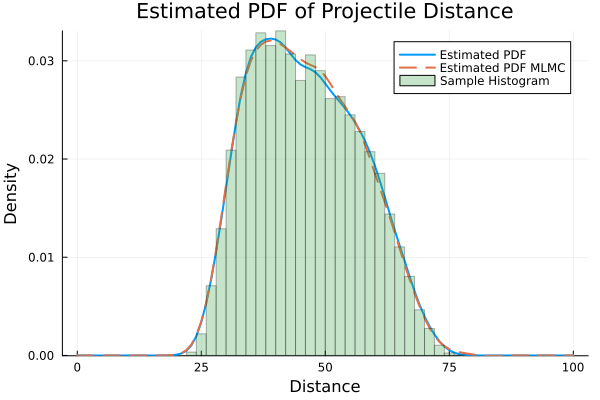

In [13]:
function kernel_density_estimation(samples, bandwidth)
    n = length(samples)
    kde = x -> (1 / (n * bandwidth)) * sum(pdf.(Normal(0, 1), (x .- samples) ./ bandwidth))
    return kde
end

function kernel_density_estimate_mlmc(mlmc_samples, bandwidth)
    function kde(x)
        n_total = 0
        estimate = 0.0
        for level in 1:length(mlmc_samples)
            if level == 1
                samples_level = mlmc_samples[level]
                n_level = length(samples_level)
                estimate += 1/n_level * sum(pdf.(Normal(0, 1), (x .- samples_level) ./ bandwidth))
            else
                samples_level = mlmc_samples[level]
                n_level = length(samples_level)
                n_total += n_level
                fine_samples = first.(samples_level)
                coarse_samples = last.(samples_level)
                estimate += 1/n_level * (sum(pdf.(Normal(0, 1), (x .- fine_samples) ./ bandwidth)) - sum(pdf.(Normal(0, 1), (x .- coarse_samples) ./ bandwidth)))
            end
        end
        return (1 / (bandwidth)) * estimate
    end
    return kde
end

samples_mlmc = simulate_mlmc_samples(projectile_distance, parameters, 0.01, variances, resolutions)
pdf_estimate = kernel_density_estimation(monte_carlo_samples, 2)
pdf_estimate_mlmc = kernel_density_estimate_mlmc(mlmc_samples, 2)
plot(
    xlabel = "Distance",
    ylabel = "Density",
    title = "Estimated PDF of Projectile Distance",
    legend = :topright,
)
xs = 0:1:100
ys = pdf_estimate.(xs)
plot!(xs, ys, label = "Estimated PDF", linewidth = 2)
ys_mlmc = pdf_estimate_mlmc.(xs)
plot!(xs, ys_mlmc, label = "Estimated PDF MLMC", linewidth = 2, linestyle = :dash)
histogram!(monte_carlo_samples, normalize = true, label = "Sample Histogram", bins = 30, alpha = 0.3, fillalpha = 0.3)
display(current())

## Using the built-in functions

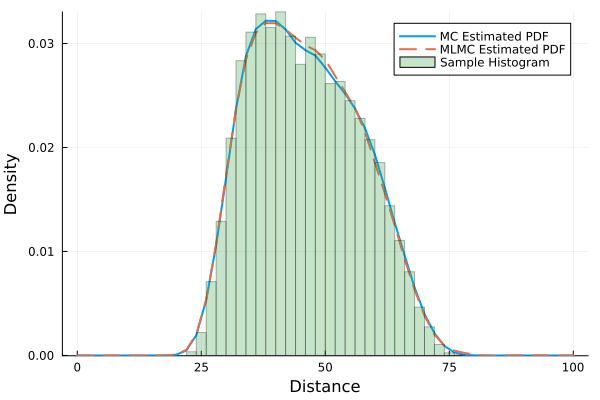

In [21]:
bandwidth = 2.0
K_h(h, x) = (1 / h) * pdf(Normal(0, 1), x / h)
pdf_monte_carlo(u) = mc_estimate(monte_carlo_samples, x -> K_h(bandwidth, u - x))
pdf_mlmc(u) = mlmc_estimate(mlmc_samples, x -> K_h(bandwidth, u - x))

distances = 0:2:100
approx_pdf_mc = pdf_monte_carlo.(distances)
approx_pdf_mlmc = pdf_mlmc.(distances)

plot(
    distances,
    approx_pdf_mc,
    label = "MC Estimated PDF",
    linewidth = 2,
    xlabel = "Distance",
    ylabel = "Density"
)
plot!(
    distances,
    approx_pdf_mlmc,
    label = "MLMC Estimated PDF",
    linewidth = 2,
    linestyle = :dash
)
histogram!(
    monte_carlo_samples,
    normalize = true,
    label = "Sample Histogram",
    bins = 30,
    alpha = 0.3,
    fillalpha = 0.3
)
display(current())

## Variance decay (not part of the exercise)

Here, we are dealing with functions: $f(x) = K_h(u - x)$ for fixed $u$. We can estimate the variance decay of the MLMC levels by taking the $L^2$ norm of the variance of the level differences, that is, we measure
$$V_\ell = \| \mathrm{Var}[K_h(u - U_\ell) - K_h(u - U_{\ell-1})] \|_2.$$

(in general, prefer to use $L^2$ norm when dealing with Monte Carlo estimates).

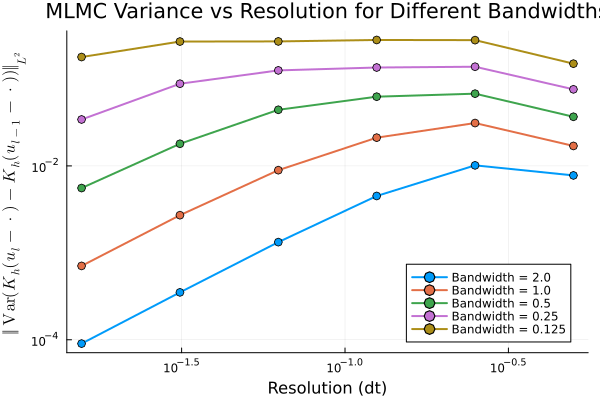

In [44]:
using LaTeXStrings
plot(
    xaxis = :log10,
    yaxis = :log10,
    xlabel = "Resolution (dt)",
    ylabel = L"\Vert\mathrm{Var}(K_h(u_l-\cdot) - K_h(u_{l-1}-\cdot))\Vert_{L^2}",
    title = "MLMC Variance vs Resolution for Different Bandwidths",
    legend = :bottomright,
)
distances = 20:5:80
for h in [2.0, 1.0, 0.5, 0.25, 0.125]
    qoi = (parameters; resolution = 0.01) -> begin
        distance = projectile_distance(parameters; resolution = resolution)
        return [K_h(h, distance - d) for d in distances]
    end
    variances = estimate_mlmc_variances(qoi, parameters, resolutions, 5000)
    plot!(resolutions, variances, label = "Bandwidth = $h", marker = :o, linewidth = 2)
end
display(current())

# Remember, you need a good heuristic or formula to determine the variance decay!